In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Parameter
r = 0
S0 = 1 
v0_sqrt = 0.2
v0 = v0_sqrt**2
kappa = 3
theta_sqrt = 0.4
theta = theta_sqrt**2
eta = 1.5
rho = -0.5


Nsims = 5000
dt = 1/1000

T = [0.25, 0.5, 1]
#len_t = int(T/dt)

K_steps = 5
K_call = np.linspace(1, 1.2, K_steps)
K_put = np.linspace(0.8, 1, K_steps)

In [3]:
# Find implied volatility

def bs_call(S, K, T, vol):
    d1 = (np.log(S/K) + (0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

def bs_put(S, K, T, vol):
    d1 = (np.log(S/K) + (0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return -S * norm.cdf(-d1) + K * norm.cdf(-d2)

def bs_vega(S, K, T, sigma):
    d1 = (np.log(S / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol_call(target_value, S, K, T, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1/1000000
    sigma = 0.3
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, sigma)
        vega = bs_vega(S, K, T, sigma)
        #print('V:' + str(vega))
        diff = target_value - price  # our root
        #print(diff)
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
        #print(sigma)
    return sigma # value wasn't found, return best guess so far

def find_vol_put(target_value, S, K, T, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1/1000000
    sigma = 0.3
    for i in range(0, MAX_ITERATIONS):
        price = bs_put(S, K, T, sigma)
        vega = bs_vega(S, K, T, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [4]:
def Risk_Neutral_Mils_col(len_t, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v, z_sim_s):
    
    var_path = np.zeros((Nsims, len_t))
    var_path[:, 0] = v0

    S_path = np.zeros((Nsims, len_t))
    S_path[:, 0] = S0

    # Euler X and Mils v
    for i in range(len_t - 1):
        
        # Milstein Simulation of variance
        var_path[:, i+1] = var_path[:,i] + \
                           kappa * (theta - np.maximum(var_path[:,i], 0)) * dt + \
                           eta * np.sqrt(np.maximum(var_path[:,i], 0)) * np.sqrt(dt) * z_sim_v[:, i] + \
                           0.25 * eta**2 * (dt * (z_sim_v[:, i])**2 - dt)
        
        # Euler Simulation of log(Stock Price)
        S_path[:, i+1] = S_path[:, i] * np.exp( \
                         - 0.5 * np.maximum(var_path[:,i], 0)  * dt + \
                         np.sqrt(np.maximum(var_path[:,i], 0)) *  np.sqrt(dt) *(z_sim_s[:, i]))

    return var_path, S_path

In [5]:
# Risk-Netrual MC simulation for T = 0.25
T1 = 0.25
len_t1 = int(T1/dt)

mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

z_sim_v = np.zeros((Nsims,len_t1))
z_sim_s = np.zeros((Nsims,len_t1))

for i in range(0, Nsims):
    W = np.random.multivariate_normal(mu, cov, size = len_t1)
    z_sim_v[i, :] = W[:,0]
    z_sim_s[i, :] = W[:,1]
    
[var_path_1, S_path_1] = Risk_Neutral_Mils_col(len_t1, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v, z_sim_s)

In [6]:
S_path_1[:,-1]-1

array([ 0.07168829, -0.06548446, -0.10487419, ...,  0.06146308,
       -0.13310103, -0.27233237])

In [7]:
fin_vol_call_1 = np.zeros(K_steps)
ci_call_up = np.zeros(K_steps) 
ci_call_low = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(S_path_1[:,-1] - K_call[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_call_1[i] = find_vol_call(mean_price, S0, K_call[i], T1)
    ci_call_up[i] = find_vol_call(price_up, S0, K_call[i], T1)
    ci_call_low[i] = find_vol_call(price_low, S0, K_call[i], T1)

In [8]:
fin_vol_put_1 = np.zeros(K_steps)
ci_put_up = np.zeros(K_steps) 
ci_put_low = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(-S_path_1[:,-1] + K_put[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_put_1[i] = find_vol_put(mean_price, S0, K_put[i], T1)
    ci_put_up[i] = find_vol_put(price_up, S0, K_put[i], T1)
    ci_put_low[i] = find_vol_put(price_low, S0, K_put[i], T1)

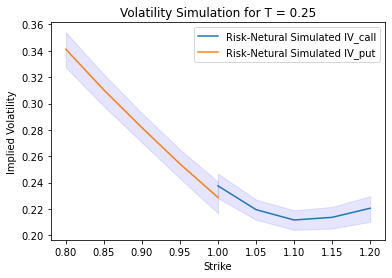

In [9]:
plt.plot(K_call, fin_vol_call_1, label='Risk-Netural Simulated IV_call')
plt.plot(K_put, fin_vol_put_1, label='Risk-Netural Simulated IV_put')
plt.fill_between(K_call, ci_call_up, ci_call_low, color='b', alpha=.1)
plt.fill_between(K_put, ci_put_up, ci_put_low, color='b', alpha=.1)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility Simulation for T = 0.25')
plt.legend()

In [10]:
# Risk-Netrual MC simulation for T = 0.5
T2 = 0.5
len_t2 = int(T2/dt)

mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

z_sim_v2 = np.zeros((Nsims,len_t2))
z_sim_s2 = np.zeros((Nsims,len_t2))

for i in range(0, Nsims):
    W = np.random.multivariate_normal(mu, cov, size = len_t2)
    z_sim_v2[i, :] = W[:,0]
    z_sim_s2[i, :] = W[:,1]
    
[var_path_2, S_path_2]= Risk_Neutral_Mils_col(len_t2, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v2, z_sim_s2)

In [19]:
len(var_path_2)

5000

In [11]:
fin_vol_call_2 = np.zeros(K_steps)
ci_call_up_2 = np.zeros(K_steps) 
ci_call_low_2 = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(S_path_2[:,-1] - K_call[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_call_2[i] = find_vol_call(mean_price, S0, K_call[i], T2)
    ci_call_up_2[i] = find_vol_call(price_up, S0, K_call[i], T2)
    ci_call_low_2[i] = find_vol_call(price_low, S0, K_call[i], T2)

In [12]:
fin_vol_put_2 = np.zeros(K_steps)
ci_put_up_2 = np.zeros(K_steps) 
ci_put_low_2 = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(-S_path_2[:,-1] + K_put[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_put_2[i] = find_vol_put(mean_price, S0, K_put[i], T2)
    ci_put_up_2[i] = find_vol_put(price_up, S0, K_put[i], T2)
    ci_put_low_2[i] = find_vol_put(price_low, S0, K_put[i], T2)

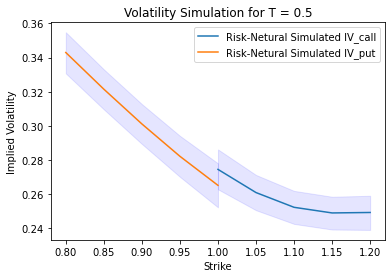

In [13]:
plt.plot(K_call, fin_vol_call_2, label='Risk-Netural Simulated IV_call')
plt.plot(K_put, fin_vol_put_2, label='Risk-Netural Simulated IV_put')
plt.fill_between(K_call, ci_call_up_2, ci_call_low_2, color='b', alpha=.1)
plt.fill_between(K_put, ci_put_up_2, ci_put_low_2, color='b', alpha=.1)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility Simulation for T = 0.5')
plt.legend()

In [14]:
# Risk-Netrual MC simulation for T = 1
T3 = 1
len_t3 = int(T3/dt)

mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

z_sim_v3 = np.zeros((Nsims,len_t3))
z_sim_s3 = np.zeros((Nsims,len_t3))

for i in range(0, Nsims):
    W = np.random.multivariate_normal(mu, cov, size = len_t3)
    z_sim_v3[i, :] = W[:,0]
    z_sim_s3[i, :] = W[:,1]
    
[var_path_3, S_path_3]= Risk_Neutral_Mils_col(len_t3, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v3, z_sim_s3)

In [ ]:
fin_vol_call_3 = np.zeros(K_steps)
ci_call_up_3 = np.zeros(K_steps) 
ci_call_low_3 = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(S_path_3[:,-1] - K_call[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_call_3[i] = find_vol_call(mean_price, S0, K_call[i], T3)
    ci_call_up_3[i] = find_vol_call(price_up, S0, K_call[i], T3)
    ci_call_low_3[i] = find_vol_call(price_low, S0, K_call[i], T3)

In [ ]:
fin_vol_put_3 = np.zeros(K_steps)
ci_put_up_3 = np.zeros(K_steps) 
ci_put_low_3 = np.zeros(K_steps) 
for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    
    #temp_S = S0 * np.ones(Nsims)
    #temp_K = K_call[i] * np.ones(Nsims)
    #temp_T = T1 * np.ones(Nsims)
    option_price = np.maximum(-S_path_3[:,-1] + K_put[i], 0)
    mean_price = np.mean(option_price)
    price_up = mean_price + 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(option_price)/np.sqrt(Nsims)
    #print(Option_Value)
    #params = np.vstack((Option_Value, temp_S, temp_K, temp_T))
    #vols = list(map(find_vol_call, *params))
   
    #some confidence interval
    
    fin_vol_put_3[i] = find_vol_put(mean_price, S0, K_put[i], T3)
    ci_put_up_3[i] = find_vol_put(price_up, S0, K_put[i], T3)
    ci_put_low_3[i] = find_vol_put(price_low, S0, K_put[i], T3)

In [ ]:
plt.plot(K_call, fin_vol_call_3, label='Risk-Netural Simulated IV_call')
plt.plot(K_put, fin_vol_put_3, label='Risk-Netural Simulated IV_put')
plt.fill_between(K_call, ci_call_up_3, ci_call_low_3, color='b', alpha=.1)
plt.fill_between(K_put, ci_put_up_3, ci_put_low_3, color='b', alpha=.1)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility Simulation for T = 1')
plt.legend()

In [ ]:
#len_t = int(T/dt) 
def Sim_Brownian_Motion_V(len_t, dt, Nsims):

    # store the paths of the Brownian motion
    W = np.zeros((Nsims,len_t))

    sqrt_dt = np.sqrt(dt)
    for i in range(len_t-1):
        W[:,i+1] = W[:,i] + sqrt_dt * np.random.randn(Nsims)

    return W

In [ ]:
def Risk_Neutral_Mils_mix(len_t, dt, Nsims, v0, S0, kappa, theta, eta, w_sim_v):
    
    var_path = np.zeros((Nsims, len_t))
    var_path[:, 0] = v0

    F_path = np.zeros((Nsims, len_t))
    F_path[:, 0] = S0
    
    b2_path = np.zeros((Nsims, len_t))
    b2_path[:, 0] = 0

    # Euler X and Mils v
    for i in range(len_t - 1):
        
        # Milstein Simulation of variance
        var_path[:, i+1] = var_path[:,i] + \
                           kappa * (theta - np.maximum(var_path[:,i], 0)) * dt + \
                           eta * np.sqrt(np.maximum(var_path[:,i], 0)) * (w_sim_v[:, i+1] - w_sim_v[:, i]) + \
                           0.25 * eta**2 * ((w_sim_v[:, i+1] - w_sim_v[:, i])**2 - dt)
        
        # Euler Simulation of Stock Price
        F_path[:, i+1] = F_path[:, i] * np.exp( \
                         - 0.5 * np.maximum(var_path[:,i], 0)  * dt 
                         + rho * np.sqrt(np.maximum(var_path[:,i], 0)) * (w_sim_v[:, i+1] - w_sim_v[:, i])\
                         + 0.5 * (1 - rho**2) * np.maximum(var_path[:,i], 0) * dt)

        b2_path[:, i+1] = b2_path[:, i] + (1 - rho**2) * np.maximum(var_path[:,i], 0) * dt
        
    return var_path, F_path, b2_path

In [ ]:
def Option_Price_Mixing_call(F0, K, b2, *arg):
    
    d1 = (np.log(F0/K) + 0.5 * b2) / np.sqrt(b2)
    d2 = (np.log(F0/K) - 0.5 * b2) / np.sqrt(b2)
    
    return F0 * norm.cdf(d1) - K * norm.cdf(d2)

def Option_Price_Mixing_put(F0, K, b2, *arg):
    
    d1 = (np.log(F0/K) + 0.5 * b2) / np.sqrt(b2)
    d2 = (np.log(F0/K) - 0.5 * b2) / np.sqrt(b2)
    
    return -F0 * norm.cdf(-d1) + K * norm.cdf(-d2)

In [ ]:
# Risk-Netrual mixing MC simulation for T = 0.25

# T1 = 0.25
# len_t1 = int(T1/dt)

w_sim_v1 = Sim_Brownian_Motion_V(len_t1, dt, Nsims)

[var_path_mix_1, F_path_1, b2_path_1]= Risk_Neutral_Mils_mix(len_t1, dt, Nsims, v0, S0, kappa, theta, eta, w_sim_v1)

In [ ]:
fin_vol_mix_call_1 = np.zeros(K_steps)
ci_call_mix_up_1 = np.zeros(K_steps) 
ci_call_mix_low_1 = np.zeros(K_steps) 

for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    temp_F0 = F_path_1[:, -1]
    temp_K = K_call[i] * np.ones(Nsims)
    temp_b2 = b2_path_1[:, -1]
    
    params_patoff = np.vstack((temp_F0, temp_K, temp_b2))
    Option_Value = list(map(Option_Price_Mixing_call, *params_patoff))
    
    mean_price = np.mean(Option_Value)
    price_up = mean_price + 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
   
    #some confidence interval
    fin_vol_mix_call_1[i] = find_vol_call(mean_price, S0, K_call[i], T1)
    ci_call_mix_up_1[i] = find_vol_call(price_up, S0, K_call[i], T1)
    ci_call_mix_low_1[i] = find_vol_call(price_low, S0, K_call[i], T1)

In [ ]:
fin_vol_mix_put_1 = np.zeros(K_steps)
ci_put_mix_up_1 = np.zeros(K_steps) 
ci_put_mix_low_1 = np.zeros(K_steps) 

for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    temp_F0 = F_path_1[:, -1]
    temp_K = K_put[i] * np.ones(Nsims)
    temp_b2 = b2_path_1[:, -1]
    
    params_patoff = np.vstack((temp_F0, temp_K, temp_b2))
    Option_Value = list(map(Option_Price_Mixing_put, *params_patoff))
    
    mean_price = np.mean(Option_Value)
    price_up = mean_price + 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
   
    #some confidence interval
    fin_vol_mix_put_1[i] = find_vol_put(mean_price, S0, K_put[i], T1)
    ci_put_mix_up_1[i] = find_vol_put(price_up, S0, K_put[i], T1)
    ci_put_mix_low_1[i] = find_vol_put(price_low, S0, K_put[i], T1)

In [ ]:
plt.plot(K_call, fin_vol_mix_call_1, label='Risk-Netural Simulated IV_call')
plt.plot(K_put, fin_vol_mix_put_1, label='Risk-Netural Simulated IV_put')
plt.fill_between(K_call, ci_call_mix_up_1, ci_call_mix_low_1, color='b', alpha=.1)
plt.fill_between(K_put, ci_put_mix_up_1, ci_put_mix_low_1, color='b', alpha=.1)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility Simulation for T = 0.25')
plt.legend()

In [ ]:
# Risk-Netrual mixing MC simulation for T = 0.5

w_sim_v2 = Sim_Brownian_Motion_V(len_t2, dt, Nsims)

[var_path_mix_2, F_path_2, b2_path_2]= Risk_Neutral_Mils_mix(len_t2, dt, Nsims, v0, S0, kappa, theta, eta, w_sim_v2)

In [ ]:
fin_vol_mix_call_2 = np.zeros(K_steps)
ci_call_mix_up_2 = np.zeros(K_steps) 
ci_call_mix_low_2 = np.zeros(K_steps) 

for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    temp_F0 = F_path_2[:, -1]
    temp_K = K_call[i] * np.ones(Nsims)
    temp_b2 = b2_path_2[:, -1]
    
    params_patoff = np.vstack((temp_F0, temp_K, temp_b2))
    Option_Value = list(map(Option_Price_Mixing_call, *params_patoff))
    
    mean_price = np.mean(Option_Value)
    price_up = mean_price + 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
   
    #some confidence interval
    fin_vol_mix_call_2[i] = find_vol_call(mean_price, S0, K_call[i], T2)
    ci_call_mix_up_2[i] = find_vol_call(price_up, S0, K_call[i], T2)
    ci_call_mix_low_2[i] = find_vol_call(price_low, S0, K_call[i], T2)

In [ ]:
fin_vol_mix_put_2 = np.zeros(K_steps)
ci_put_mix_up_2 = np.zeros(K_steps) 
ci_put_mix_low_2 = np.zeros(K_steps) 

for i in range(0, K_steps):
    
    #temp_K = K[i]
    #temp_vol = np.zeros(Nsims)
    temp_F0 = F_path_2[:, -1]
    temp_K = K_put[i] * np.ones(Nsims)
    temp_b2 = b2_path_2[:, -1]
    
    params_patoff = np.vstack((temp_F0, temp_K, temp_b2))
    Option_Value = list(map(Option_Price_Mixing_put, *params_patoff))
    
    mean_price = np.mean(Option_Value)
    price_up = mean_price + 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
    price_low = mean_price - 1.96 * np.nanstd(Option_Value)/np.sqrt(Nsims)
   
    #some confidence interval
    fin_vol_mix_put_2[i] = find_vol_put(mean_price, S0, K_put[i], T2)
    ci_put_mix_up_2[i] = find_vol_put(price_up, S0, K_put[i], T2)
    ci_put_mix_low_2[i] = find_vol_put(price_low, S0, K_put[i], T2)

In [ ]:
plt.plot(K_call, fin_vol_mix_call_2, label='Risk-Netural Simulated IV_call')
plt.plot(K_put, fin_vol_mix_put_2, label='Risk-Netural Simulated IV_put')
plt.fill_between(K_call, ci_call_mix_up_2, ci_call_mix_low_2, color='b', alpha=.1)
plt.fill_between(K_put, ci_put_mix_up_2, ci_put_mix_low_2, color='b', alpha=.1)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Volatility Simulation for T = 0.5')
plt.legend()

In [20]:
def contingent_Analytical(T):
    cont_claim = theta * T + (1 - np.exp(-kappa *T)) * (v0 - theta)/kappa
    return cont_claim


def contingent_Sim(T,dt,var_path_1):
    nSim = len(var_path_1[:,1])
    
    simulated_vals = []
    for ii in range(nSim):
        # for each iteration we get a list of values (250)
        y_value = var_path_1[ii,:]
        num_of_y = len(y_value)

        # the index of values at left
        #x_left = np.linspace(0,num_of_y-1, num_of_y)
        
        # calculate contingent by left riemann sum
        
        left_riemann_sum = np.sum(y_value[0:num_of_y-1] * dt)
        simulated_vals.append(max(left_riemann_sum,0))
    return np.mean(simulated_vals)


def contingent_Analytical_sqr(T):
    part = (2 * kappa * theta + eta **2) / (2 * kappa)
    part1 = part * theta * T
    part2 = (v0**2 - part * (2*v0 - theta)) * (1 - np.exp(-2*kappa*T))/ (2 *kappa)
    part3 = part *2*(v0 - theta) * (1-np.exp(- kappa * T))/ kappa
    cont_claim = part1 + part2 + part3
    return cont_claim

def contingent_Sim_sqr(T,dt,var_path_1):
    nSim = len(var_path_1[:,1])
    
    simulated_vals = []
    for ii in range(nSim):
        # for each iteration we get a list of values (250)
        y_value = var_path_1[ii,:]
        num_of_y = len(y_value)

        # the index of values at left
        #x_left = np.linspace(0,num_of_y-1, num_of_y)
        
        # calculate contingent by left riemann sum
        
        left_riemann_sum = np.sum(y_value[0:num_of_y-1]**2 * dt)
        simulated_vals.append(max(left_riemann_sum,0))
    return np.mean(simulated_vals)

In [ ]:
#Question 2

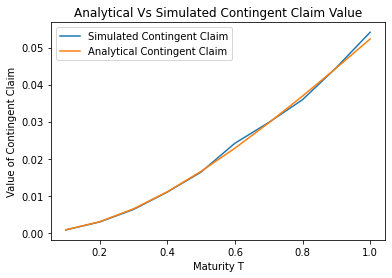

In [21]:
def plot_value_sqr():
    T = np.linspace(0.1, 1,10)
    simulated_list = []
    analytical_list = []
    for item in T:
        len_t = int(item/dt)
        mu = np.array([0,0])
        cov = np.array([[1, rho] , [rho , 1]])

        z_sim_v = np.zeros((Nsims,len_t))
        z_sim_s = np.zeros((Nsims,len_t))
        for i in range(0, Nsims):
            W = np.random.multivariate_normal(mu, cov, size = len_t)
            z_sim_v[i, :] = W[:,0]
            z_sim_s[i, :] = W[:,1]
        [var_path, S_path] = Risk_Neutral_Mils_col(len_t, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v, z_sim_s)
        sim = contingent_Sim_sqr(item,dt,var_path)
        simulated_list.append(sim)
        
        ana = contingent_Analytical_sqr(item)
        analytical_list.append(ana)
    plt.plot(T, simulated_list, label='Simulated Contingent Claim')
    plt.plot(T, analytical_list, label='Analytical Contingent Claim')
    #plt.fill_between(K_call, ci_call_up, ci_call_low, color='b', alpha=.1)
    #plt.fill_between(K_put, ci_put_up, ci_put_low, color='b', alpha=.1)
    plt.xlabel('Maturity T')
    plt.ylabel('Value of Contingent Claim')
    plt.title('Analytical Vs Simulated Contingent Claim Value')
    plt.legend()

plot_value_sqr()

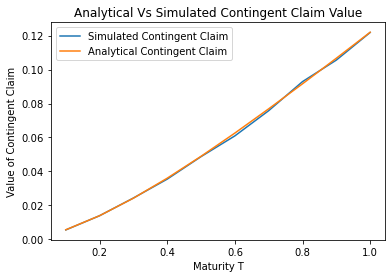

In [22]:
def plot_value():
    T = np.linspace(0.1, 1,10)
    simulated_list = []
    analytical_list = []
    for item in T:
        len_t = int(item/dt)
        mu = np.array([0,0])
        cov = np.array([[1, rho] , [rho , 1]])

        z_sim_v = np.zeros((Nsims,len_t))
        z_sim_s = np.zeros((Nsims,len_t))
        for i in range(0, Nsims):
            W = np.random.multivariate_normal(mu, cov, size = len_t)
            z_sim_v[i, :] = W[:,0]
            z_sim_s[i, :] = W[:,1]
        [var_path, S_path] = Risk_Neutral_Mils_col(len_t, dt, Nsims, v0, S0, kappa, theta, eta, z_sim_v, z_sim_s)
        sim = contingent_Sim(item,dt,var_path)
        simulated_list.append(sim)
        
        ana = contingent_Analytical(item)
        analytical_list.append(ana)
    plt.plot(T, simulated_list, label='Simulated Contingent Claim')
    plt.plot(T, analytical_list, label='Analytical Contingent Claim')
    #plt.fill_between(K_call, ci_call_up, ci_call_low, color='b', alpha=.1)
    #plt.fill_between(K_put, ci_put_up, ci_put_low, color='b', alpha=.1)
    plt.xlabel('Maturity T')
    plt.ylabel('Value of Contingent Claim')
    plt.title('Analytical Vs Simulated Contingent Claim Value')
    plt.legend()
    
plot_value()  